In [44]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib as mpl
import pandas as pd
import numpy as np
from iminuit import Minuit
from scipy import stats
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os, sys
sys.path.append('..')
from functions import read_data, overview_plot_leak, dict_for_treatment
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, nice_string_output, add_text_to_ax

In [2]:
path = '../../../KU/Bachelor+Research/Data/Axetris/Own setup/'

In [3]:
leak_test = read_data(path)

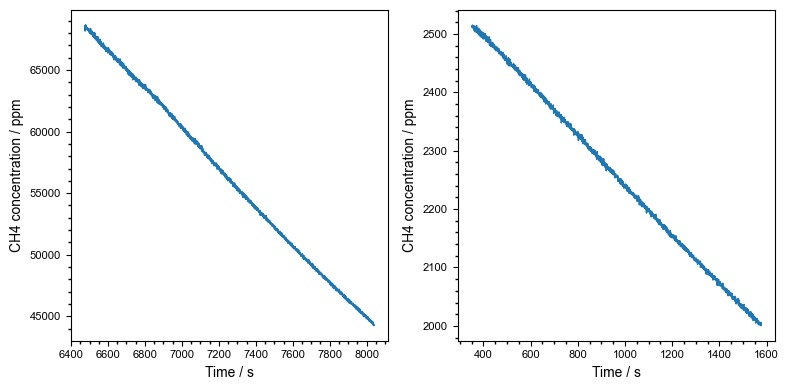

In [4]:
fig, ax = plt.subplots(1,2, figsize = (8, 4))

overview_plot_leak(ax[0], leak_test['Leak_test1_05032024'][4400:7600])
overview_plot_leak(ax[1], leak_test['Leak_test2_05032024'][700:-1])

fig.tight_layout()
fig.savefig('leak_test.png', dpi = 600)
plt.show()

In [5]:
idx_leak = np.array([[4400, 7600], [700, -1]])

leak_treat = dict_for_treatment(leak_test, idx_leak)

c:\Users\nan25\OneDrive\Dokumenter\GitHub\Manganese-chlorides\ISAMO\functions.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Seconds'] = df['Seconds'] - df['Seconds'][0]


In [60]:
array_a = np.zeros(len(leak_treat.keys()))
array_b = np.zeros(len(leak_treat.keys()))
array_ea = np.zeros(len(leak_treat.keys()))
array_eb = np.zeros(len(leak_treat.keys()))
array_Chi2 = np.zeros(len(leak_treat.keys()))
array_ndf = np.zeros(len(leak_treat.keys()))
array_Prob = np.zeros(len(leak_treat.keys()))

for i, key in enumerate(leak_treat.keys()):
    x = leak_treat[key]['Seconds']
    y = leak_treat[key]['CH4 [ppm]']
    ey = np.zeros(len(y)) + 250
    Npoints = len(y)

    def fit_func(x, a, b):
        return b * np.exp(a * x)

    def fit_func2(x, a, b):
        return a * x + b

    def chi2_owncalc(a, b) :
        y_fit = fit_func(x, a, b)
        chi2 = np.sum(((y - y_fit) / ey)**2)
        return chi2
    chi2_owncalc.errordef = 1.0    # Chi2 definition (for Minuit)

    # Here we let Minuit know, what to minimise, how, and with what starting parameters:   
    minuit = Minuit(chi2_owncalc, a = -1, b = 2000)  # , alpha1=0.0   # Own alternative

    # Perform the actual fit:
    minuit.migrad();

    # Extract the fitting parameters and their errors:
    a_fit = minuit.values['a']
    b_fit = minuit.values['b']
    sigma_a_fit = minuit.errors['a']
    sigma_b_fit = minuit.errors['b']

    Nvar = 2                     # Number of variables 
    Ndof_fit = Npoints - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

    # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom 

    array_a[i] = a_fit
    array_b[i] = b_fit
    array_ea[i] = sigma_a_fit
    array_eb[i] = sigma_b_fit
    array_Chi2[i] = Chi2_fit
    array_ndf[i] = Ndof_fit
    array_Prob[i] = Prob_fit

    print(f"{key}  Fit: a={a_fit:6.6f}+-{sigma_a_fit:5.8f}  b={b_fit:5.3f}+-{sigma_b_fit:5.3f}  p={Prob_fit:6.6f}")

Leak_test1_05032024  Fit: a=-0.000279+-0.00000018  b=69407.175+-9.787  p=0.000000
Leak_test2_05032024  Fit: a=-0.000188+-0.00000627  b=2526.759+-10.555  p=1.000000


C:\Users\nan25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [65]:
def plot_fit(ax, df, a, b, ea, eb, chi2, ndf, prob):
    x1, y1 = df['Seconds'], df['CH4 [ppm]']
    ax.plot(x1, y1, label = 'Measured CH4 conc')
    ax.plot(x1, fit_func(x1, a, b), label = 'Fitted CH4 conc')
    ax.legend(frameon = False, fontsize = 9)
    ax.set(xlabel = 'Time / s', ylabel = 'CH4 concentration / ppm')
    d = {'a':   [a, ea],
         'b':   [b, eb],
        'Chi2':     chi2,
        'Ndf':      ndf,
        'Prob':     prob,
        }
    text = nice_string_output(d, extra_spacing=2, decimals=7)
    add_text_to_ax(0.02, 0.25, text, ax, fontsize=9)

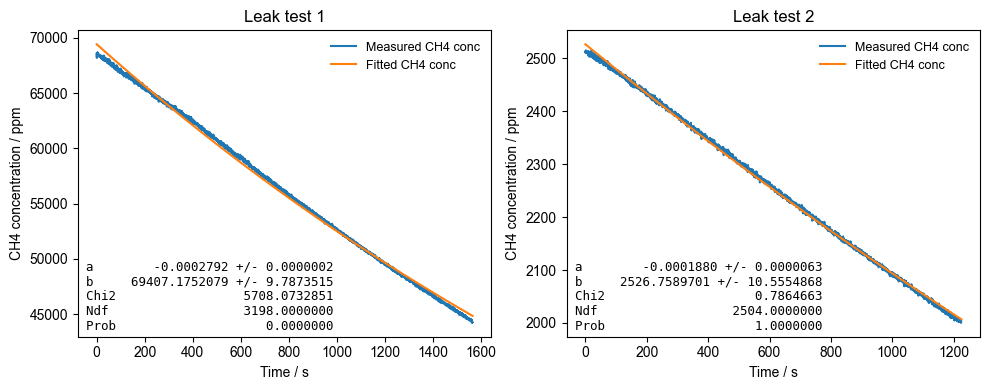

In [66]:
fig, ax = plt.subplots(1,2, figsize = (10, 4))

for i, key in enumerate(leak_treat.keys()):
    plot_fit(ax[i], leak_treat[key], array_a[i], array_b[i], array_ea[i], array_eb[i], array_Chi2[i], array_ndf[i], array_Prob[i])
ax[0].set_title('Leak test 1')
ax[1].set_title('Leak test 2')

fig.tight_layout()
fig.savefig('Fitted_leak.png', dpi = 600)
plt.show()